### [1] Import dependencies ###

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames
import seaborn as sns
import matplotlib.pyplot as plt

# Import supplementary visualization code visuals.py
# import visuals as vs

import my

# Pretty display for notebooks
%matplotlib inline

/Users/thchang/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### [2] Exploring the Data ###

In [2]:

inputFile = "/Users/thchang/Documents/dev/personal/ml/connect/git/projects/machine-learning/projects/capstone/data/ebay-query-aspects/query-cat-data.csv"

dataDF = pd.read_table(inputFile)

queryDF = dataDF.drop(['aspect', 'weight0', 'weight1'], axis = 1).drop_duplicates()
aspectDF = dataDF.drop(['query', 'weight0', 'weight1'], axis=1).drop_duplicates()

display(queryDF.head())

,query
0,.177 pellets orange crosman
5,.22 cal. pellets h 26n baracuda
10,.22 hunting pellets sample
22,.350 round ball mold
30,.355 tapered graphite iron shaft


#### Visualize Query ####

,count
count,405787.000000
mean,4.031899
std,1.799874
min,1.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,26.000000


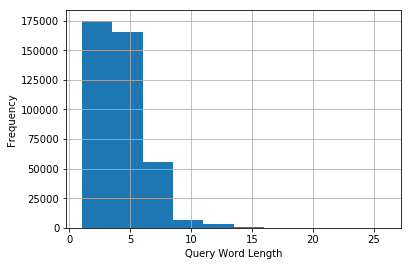

In [14]:
queryDF["count"]= queryDF["query"].apply(lambda s: len(s.split(" ")))

#display(queryDF.head())

queryDF['count'].hist(bins=10)
plt.xlabel('Query Word Length')
plt.ylabel('Frequency')

display(queryDF.describe())


#### Visualize aspects ####

,countTagName
count,94689.000000
mean,1.405443
std,0.633594
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,7.000000


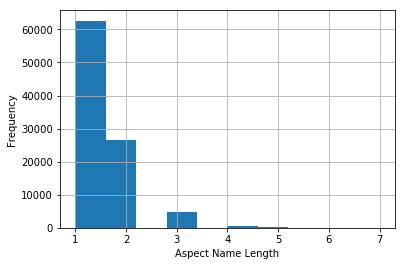

In [12]:
aspectDF["countTagName"]= aspectDF["aspect"].apply(lambda s: len((s.split("##")[0]).split(" ")))

aspectDF['countTagName'].hist(bins=10)
plt.xlabel('Aspect Name Length')
plt.ylabel('Frequency')

display(aspectDF.describe())

#display(aspectDF)

### [3] GLOVE Benchmark ###
- http://nadbordrozd.github.io/blog/2016/05/20/text-classification-with-word2vec/
- https://nlp.stanford.edu/projects/glove/
- https://github.com/stanfordnlp/GloVe

#### [Option1] Using Glove demo.sh in https://github.com/stanfordnlp/GloVe #### 

In [2]:
# cd /Users/thchang/Documents/dev/git/GloVe
# Full process: ./demo.sh
# 

####  [Option2] Using http://nadbordrozd.github.io/blog/2016/05/20/text-classification-with-word2vec/ ####

In [5]:
# Leverage GLOVE embeddings

import numpy as np
inputFileName = "./glove/glove.6B.50d.txt"
with open(inputFileName, "rb") as lines:
    w2v = {line.split()[0]: np.array(map(float, line.split()[1:]))
           for line in lines}

In [6]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(word2vec.itervalues().next())

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])
    
class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = len(word2vec.itervalues().next())

    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesClassifier

etree_w2v = Pipeline([
    ("word2vec vectorizer", MeanEmbeddingVectorizer(w2v)),
    ("extra trees", ExtraTreesClassifier(n_estimators=200))])

In [21]:

training_data_simple = [
     ['Berlin', 'London'],
     ['cow', 'cat'],
     ['pink', 'yellow']]
label_simple = ['capitals', 'animals', 'colors']
test_simple = [['dog'], ['red'], ['Madrid']]


# never before seen words!!!
training_data_castone = []
label_capstone = [] # ååå
test_capstone = [['Nearest to Genre'], ['Nearest to Vehicle_Mileage'] ,['nike'] ,['Brand_Type'] ,['Character_Family'],['Case_Size'],['dress'],['Type'],['Band_Color'],['Brand: Color'],['Size_(Women)'],['black'],['womens'],['mens'],['Publication_Year'],['2']]

X = training_data_simple
y = label_simple
test_X = test_simple

etree_w2v.fit(X, y)

print etree_w2v.predict(test_X)

['animals' 'colors' 'capitals']


####  [Option3] Use predefined web service ####
http://bionlp-www.utu.fi/wv_demo/